# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import time

%matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [17]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
web = []
email = []
mobile = []
social = []
for row in portfolio.itertuples():
    if "web" in row.channels:
        web.append(1)
    else:
        web.append(0)
    if "email" in row.channels:
        email.append(1)
    else:
        email.append(0)
    if  "mobile" in row.channels:
        mobile.append(1)
    else:
        mobile.append(0)
    if "social" in row.channels:
        social.append(1)
    else:
        social.append(0)
portfolio["channel_type_web"] = web
portfolio["channel_type_email"] = email
portfolio["channel_type_mobile"] = mobile
portfolio["channel_type_social"] = social

In [4]:
portfolio = pd.get_dummies(portfolio, columns=["offer_type"])

In [5]:
portfolio.drop(["channels"], axis=1, inplace=True)

In [6]:
portfolio.head()

,difficulty,duration,id,reward,channel_type_web,channel_type_email,channel_type_mobile,channel_type_social,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [8]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [9]:
transcript_copy = pd.read_json('data/transcript.json', orient='records', lines=True)

In [10]:
transcript["event"].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [11]:
transcript[transcript["event"] == "transaction"]["value"].head()

12654    {'amount': 0.8300000000000001}
12657                 {'amount': 34.56}
12659                 {'amount': 13.23}
12670                 {'amount': 19.51}
12671                 {'amount': 18.97}
Name: value, dtype: object

In [12]:
transcript[transcript["event"] == "offer received"]["value"].head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [13]:
transcript[transcript["event"] == "offer viewed"]["value"].head()

12650    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
Name: value, dtype: object

In [14]:
transcript[transcript["event"] == "offer completed"]["value"].head()

12658    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679    {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692    {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
Name: value, dtype: object

The data type of "value" column depends on the "event" values. I'll process them manually.

In [15]:
# lists for dummies
transaction = []
offer_received = []
offer_viewed = []
offer_completed = []

offer_ids= []
transaction_amounts = []
complete_rewards = []

for row in transcript.itertuples():
    event = row.event
    
    if event == "transaction":
        transaction.append(1)
        transaction_amounts.append(row.value.get("amount"))
        
        
        offer_received.append(0)
        offer_viewed.append(0)
        offer_completed.append(0)
        offer_ids.append(None)
        complete_rewards.append(np.nan)

    elif event == "offer received":
        offer_received.append(1)
        offer_ids.append(row.value.get("offer id"))
        
        offer_viewed.append(0)
        offer_completed.append(0)
        transaction.append(0)
        transaction_amounts.append(np.nan)
        complete_rewards.append(np.nan)

    elif event == "offer viewed":
        offer_viewed.append(1)
        offer_ids.append(row.value.get("offer id"))
        
        offer_received.append(0)
        offer_completed.append(0)
        complete_rewards.append(np.nan)
        transaction.append(0)
        transaction_amounts.append(np.nan)
        
    else: # offer complete
        offer_completed.append(1)
        offer_ids.append(row.value.get("offer_id"))
        complete_rewards.append(row.value.get("reward"))
        
        offer_received.append(0)
        offer_viewed.append(0)
        transaction.append(0)
        transaction_amounts.append(np.nan)

transcript["event_type_offer_received"] = offer_received
transcript["event_type_offer_viewed"] = offer_viewed
transcript["event_type_transaction"] = transaction
transcript["event_type_offer_completed"] = offer_completed

transcript["offer_id"] = offer_ids
transcript["transaction_amount"] = transaction_amounts
transcript["reward_amount"] = complete_rewards



In [16]:
transcript.drop(["event", "value"], axis=1, inplace=True)

In [17]:
transcript.head()

,person,time,event_type_offer_received,event_type_offer_viewed,event_type_transaction,event_type_offer_completed,offer_id,transaction_amount,reward_amount
0,78afa995795e4d85b5d9ceeca43f5fef,0,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,1,0,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,0,1,0,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,1,0,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,1,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [18]:
# cleaning up rounding errors
transcript["transaction_amount"] = transcript["transaction_amount"].apply(lambda x: round(x, 2))
transcript["reward_amount"] = transcript["reward_amount"].apply(lambda x: round(x, 2))

In [272]:
# Maunually unit testing the transcript df dummies


In [19]:
assert transcript[transcript["event_type_transaction"] == 1]["event_type_transaction"].count() == transcript_copy[transcript_copy["event"] == "transaction"]["event"].count(), "transaction counts are incorrect"
print("transaction test: pass")

assert transcript[transcript["event_type_offer_received"] == 1]["event_type_offer_received"].count() == transcript_copy[transcript_copy["event"] == "offer received"]["event"].count(), "offer received counts are incorrect"
print("offer received test: pass")

transcript[transcript["event_type_offer_viewed"] == 1]["event_type_offer_viewed"].count()  == transcript_copy[transcript_copy["event"] == "offer viewed"]["event"].count(), "offer viewed counts are incorrect"
print("offer viewed test: pass")

transcript[transcript["event_type_offer_completed"] == 1]["event_type_offer_completed"].count()  == transcript_copy[transcript_copy["event"] == "offer completed"]["event"].count(), "offer completed counts are incorrect"
print("offer completed test: pass")


transaction test: pass
offer received test: pass
offer viewed test: pass
offer completed test: pass


In [20]:
profile = pd.read_json('data/profile.json', orient='records', lines=True)

In [21]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [22]:
profile["became_member_on"].max() # getting the last date a customer has joined in this dataset

20180726

In [23]:
ref_date = datetime.datetime(2018, 7, 26) # using the last date joined as a reference date to compute the customer tenure length

In [24]:
tenure_lengths = []
joined_dates = []
for row in profile.itertuples():
    date = row.became_member_on
    joined_date = datetime.datetime(int(str(date)[0:4]), int(str(date)[4:6]), int(str(date)[6:8]))
    days_delta = ref_date - joined_date
    days_delta = days_delta.days
    tenure_lengths.append(days_delta)
    joined_dates.append(joined_date)
profile["tenure_length"] = tenure_lengths
profile["joined_date"] = joined_dates

In [25]:
profile.drop(["became_member_on"], axis=1, inplace=True)

In [26]:
profile["age"] = profile["age"].replace([118], np.nan)

In [27]:
profile.head()

,age,gender,id,income,tenure_length,joined_date
0,NaN,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15
2,NaN,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09
4,NaN,None,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04


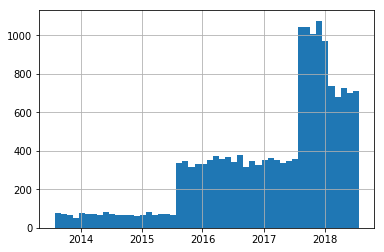

In [28]:
profile["joined_date"].hist(bins=50);

In [29]:
profile_copy = profile.copy()

In [30]:
profile_copy.index = profile_copy["joined_date"]

In [31]:
joined_date_hist = profile_copy.groupby(pd.Grouper(freq='M')).describe()

In [32]:
joined_date_hist.iloc[0:, 0]

joined_date
2013-07-31      5.0
2013-08-31     64.0
2013-09-30     55.0
2013-10-31     53.0
2013-11-30     46.0
2013-12-31     51.0
2014-01-31     62.0
2014-02-28     54.0
2014-03-31     54.0
2014-04-30     61.0
2014-05-31     64.0
2014-06-30     56.0
2014-07-31     54.0
2014-08-31     57.0
2014-09-30     55.0
2014-10-31     47.0
2014-11-30     51.0
2014-12-31     47.0
2015-01-31     61.0
2015-02-28     60.0
2015-03-31     59.0
2015-04-30     58.0
2015-05-31     64.0
2015-06-30     53.0
2015-07-31     64.0
2015-08-31    242.0
2015-09-30    238.0
2015-10-31    233.0
2015-11-30    228.0
2015-12-31    237.0
              ...  
2016-02-29    237.0
2016-03-31    256.0
2016-04-30    266.0
2016-05-31    262.0
2016-06-30    250.0
2016-07-31    271.0
2016-08-31    262.0
2016-09-30    233.0
2016-10-31    253.0
2016-11-30    245.0
2016-12-31    240.0
2017-01-31    250.0
2017-02-28    239.0
2017-03-31    236.0
2017-04-30    252.0
2017-05-31    234.0
2017-06-30    260.0
2017-07-31    345.0
2017-08-

In [33]:
profile.to_csv("profile_datetime.csv")

In [34]:
joined_date_hist.iloc[:, 0].sum()

14825.0

In [35]:
joined_date_hist.iloc[0:25, 0].sum()

1355.0

In [36]:
joined_date_hist.iloc[25:49, 0].sum()

6018.0

In [37]:
joined_date_hist.iloc[50:55, 0].sum()

3718.0

In [38]:
joined_date_hist.iloc[55:, 0].sum()

2964.0

There seems to be abrupt changes in the number of newly joined customers around mid 2015, mid 2017, and early 2018. This might indicate that different numbers of samples were taken from different time frames. We should keep this in mind, especially when we generalize the findings at the end of this study.

In [39]:
profile.columns

Index(['age', 'gender', 'id', 'income', 'tenure_length', 'joined_date'], dtype='object')

In [40]:
gender_dummies = pd.get_dummies(profile["gender"])

In [41]:
gender_dummies.columns = ["Female", "Male", "Other"]

In [42]:
profile = pd.concat([profile, gender_dummies], axis=1)

In [43]:
profile.drop("gender", axis=1, inplace=True)

In [44]:
profile.head()

,age,id,income,tenure_length,joined_date,Female,Male,Other
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12,0,0,0
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15,1,0,0
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12,0,0,0
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09,1,0,0
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04,0,0,0


In [45]:
profile["tenure_length"].describe()

count    17000.000000
mean       517.449882
std        411.223904
min          0.000000
25%        208.000000
50%        358.000000
75%        791.000000
max       1823.000000
Name: tenure_length, dtype: float64

In [46]:
t1 = time.time()
total_transaction_amounts = []
for row in profile.itertuples():
    total_transaction_amounts.append(transcript[transcript["person"] == row.id]["transaction_amount"].sum())
print(time.time() - t1)

264.6822807788849


In [47]:
profile["total_transaction_amount"] = total_transaction_amounts

In [48]:
total_reward_amounts = []
for row in profile.itertuples():
    total_reward_amounts.append(transcript[transcript["person"] == row.id]["reward_amount"].sum())

In [49]:
profile["total_reward_amount"] = total_reward_amounts

In [50]:
profile.to_csv("profile_checkpoint1.csv", index=False)

In [51]:
profile = pd.read_csv("profile_checkpoint1.csv")

In [173]:
(portfolio[portfolio["id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9"]["channel_type_web"].values)[0]

1

In [171]:
portfolio

,difficulty,duration,id,reward,channel_type_web,channel_type_email,channel_type_mobile,channel_type_social,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [182]:
def compute_successful_discounts_by_type(customer_id, offer_type, transcript=transcript, portfolio=portfolio):
    
    offer_type = offer_type
    offer_ids = []
    offer_received_times = []
    offer_viewed_times = []
    offer_completed_times = []
    offer_end_times = []
    offer_types = []
    receive_to_view_times = []
    view_to_complete_times = []
    success = []
    web = []
    email = []
    mobile = []
    social = []

    df_single_customer_transcript = transcript[(transcript["person"] == customer_id)]
    
    received_offers = transcript[(transcript["person"] == customer_id) & (transcript["event_type_offer_received"] == 1)]["offer_id"]

    # select the specific type of offers only
    informational_ids = list(portfolio[portfolio["offer_type_informational"] == 1]["id"].values)
    bogo_ids = list(portfolio[portfolio["offer_type_bogo"] == 1]["id"].values)
    discount_ids = list(portfolio[portfolio["offer_type_discount"] == 1]["id"].values)

    if offer_type == "bogo":
        del_offer_ids = informational_ids + discount_ids
    elif offer_type == "discount":
        del_offer_ids = informational_ids + bogo_ids
    elif offer_type == "informational":
        del_offer_ids = discount_ids + bogo_ids

    for offer_id in del_offer_ids:
        received_offers = received_offers.drop(received_offers[received_offers == offer_id].index)

    total_offers_count = received_offers.count()

    # select the offers that worked
    for idx, offer_id in received_offers.items():

        # get the time when an offer was received
        offer_start_time = transcript.iloc[idx, 1]
        
        # get the length of time the offer is in effect
        offer_effective_days = portfolio[portfolio["id"] == offer_id]["duration"].values[0]
        
        # calculate the time the offer expires
        offer_end_time = offer_start_time + offer_effective_days * 24

        # get the time the offer was viewed and completed, if such event takes place
        offer_viewed_time = df_single_customer_transcript[(df_single_customer_transcript["offer_id"] == offer_id) & (df_single_customer_transcript["event_type_offer_viewed"] == 1) & (df_single_customer_transcript["time"] >= offer_start_time) & (df_single_customer_transcript["time"] <= offer_end_time)]["time"].values

        # record completed time, except for informational offers as they have no complete time stamps
        if offer_type != "informational":
            offer_completed_time = df_single_customer_transcript[(df_single_customer_transcript["offer_id"] == offer_id) & (df_single_customer_transcript["event_type_offer_completed"] == 1) & (df_single_customer_transcript["time"] >= offer_start_time) & (df_single_customer_transcript["time"] <= offer_end_time)]["time"].values
        
        
        # Record offer information
        offer_ids.append(offer_id)
        offer_received_times.append(offer_start_time)
        offer_viewed_times.append(offer_viewed_time[0])
        offer_end_times.append(offer_end_time)
        offer_types.append(offer_type)
        receive_to_view_times.append(offer_viewed_time[0] - offer_start_time)
            
        if offer_type != "informational" and len(offer_completed_time) > 0:
            offer_completed_times.append(offer_completed_time[0])
            view_to_complete_times.append(offer_completed_time[0] - offer_viewed_time[0])
        elif offer_type != "informational" and len(offer_completed_time) == 0:
            offer_completed_times.append(np.nan)
            view_to_complete_times.append(np.nan)
        elif offer_type == "informational":
            offer_completed_times.append(np.nan)
            view_to_complete_times.append(np.nan)
            
        # check if the offer was effective
        if offer_type != "informational" and len(offer_viewed_time) > 0 and offer_viewed_time[0] <= offer_end_time and len(offer_completed_time) > 0 and offer_completed_time[0] <= offer_end_time and offer_viewed_time[0] <= offer_completed_time[0]:
            success.append(1)  
        elif offer_type == "informational" and len(offer_viewed_time) > 0 and offer_viewed_time[0] <= offer_end_time and offer_viewed_time[0] >= offer_start_time:
            success.append(1)
        else:
            success.append(0)
        
        # Determine the sources of the offer
        web.append((portfolio[portfolio["id"] == offer_id]["channel_type_web"].values)[0])
        email.append((portfolio[portfolio["id"] == offer_id]["channel_type_email"].values)[0])
        mobile.append((portfolio[portfolio["id"] == offer_id]["channel_type_mobile"].values)[0])
        social.append((portfolio[portfolio["id"] == offer_id]["channel_type_social"].values)[0])
        
    # Wrap the results inside a dictionary
    offers = {
        "offer_ids": tuple(offer_ids),
        "offer_received_times": tuple(offer_received_times),
        "offer_viewed_times": tuple(offer_viewed_times),
        "offer_completed_times": tuple(offer_completed_times),
        "offer_end_times": tuple(offer_end_times),
        "offer_types": tuple(offer_types),
        "receive_to_view_times": tuple(receive_to_view_times),
        "view_to_complete_times": tuple(view_to_complete_times),
        "success": tuple(success),
        "total_offers_count": total_offers_count,
        "web": tuple(web),
        "email": tuple(email),
        "mobile": tuple(mobile),
        "social": tuple(social)
    } 
    
    return offers

    

In [119]:
df_single_customer_transcript = transcript[(transcript["person"] == "389bc3fa690240e798340f5a15918d5c")]

In [122]:
df_single_customer_transcript

,person,time,event_type_offer_received,event_type_offer_viewed,event_type_transaction,event_type_offer_completed,offer_id,transaction_amount,reward_amount
5,389bc3fa690240e798340f5a15918d5c,0,1,0,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
12650,389bc3fa690240e798340f5a15918d5c,0,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
32625,389bc3fa690240e798340f5a15918d5c,60,0,0,1,0,None,9.54,NaN
32626,389bc3fa690240e798340f5a15918d5c,60,0,0,0,1,f19421c1d4aa40978ebb69ca19b0e20d,NaN,5.0
53179,389bc3fa690240e798340f5a15918d5c,168,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
77212,389bc3fa690240e798340f5a15918d5c,192,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
110831,389bc3fa690240e798340f5a15918d5c,336,1,0,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
132803,389bc3fa690240e798340f5a15918d5c,354,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
150601,389bc3fa690240e798340f5a15918d5c,408,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
179953,389bc3fa690240e798340f5a15918d5c,438,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN


In [133]:
comp_time = df_single_customer_transcript[(df_single_customer_transcript["offer_id"] == "9b98b8c7a33c4b65b9aebfe6a799e6d9") & (df_single_customer_transcript["event_type_offer_completed"] == 1) & (df_single_customer_transcript["time"] >= 168) & (df_single_customer_transcript["time"] <= 336)]["time"].values

In [134]:
len(comp_time)

0

In [175]:
results = compute_successful_discounts_by_type("389bc3fa690240e798340f5a15918d5c", "bogo")
results

4


{'offer_ids': ('f19421c1d4aa40978ebb69ca19b0e20d',
  '9b98b8c7a33c4b65b9aebfe6a799e6d9',
  '9b98b8c7a33c4b65b9aebfe6a799e6d9',
  'f19421c1d4aa40978ebb69ca19b0e20d'),
 'offer_received_times': (0, 168, 408, 504),
 'offer_viewed_times': (0, 192, 438, 504),
 'offer_completed_times': (60, nan, 498, 600),
 'offer_end_times': (120, 336, 576, 624),
 'offer_types': ('bogo', 'bogo', 'bogo', 'bogo'),
 'receive_to_view_times': (0, 24, 30, 0),
 'view_to_complete_times': (60, nan, 60, 96),
 'success': (1, 0, 1, 1),
 'total_offers_count': 4,
 'web': (1, 1, 1, 1),
 'email': (1, 1, 1, 1),
 'mobile': (1, 1, 1, 1),
 'social': (1, 0, 0, 1)}

In [176]:
results = compute_successful_discounts_by_type("389bc3fa690240e798340f5a15918d5c", "discount")
results

2


{'offer_ids': ('2906b810c7d4411798c6938adc9daaa5',
  'fafdcd668e3743c1bb461111dcafc2a4'),
 'offer_received_times': (336, 576),
 'offer_viewed_times': (354, 588),
 'offer_completed_times': (498, 600),
 'offer_end_times': (504, 816),
 'offer_types': ('discount', 'discount'),
 'receive_to_view_times': (18, 12),
 'view_to_complete_times': (144, 12),
 'success': (1, 1),
 'total_offers_count': 2,
 'web': (1, 1),
 'email': (1, 1),
 'mobile': (1, 1),
 'social': (0, 1)}

In [177]:
results = compute_successful_discounts_by_type("389bc3fa690240e798340f5a15918d5c", "informational")
results

0


{'offer_ids': (),
 'offer_received_times': (),
 'offer_viewed_times': (),
 'offer_completed_times': (),
 'offer_end_times': (),
 'offer_types': (),
 'receive_to_view_times': (),
 'view_to_complete_times': (),
 'success': (),
 'total_offers_count': 0,
 'web': (),
 'email': (),
 'mobile': (),
 'social': ()}

In [ ]:
78afa995795e4d85b5d9ceeca43f5fef

In [178]:
results = compute_successful_discounts_by_type("78afa995795e4d85b5d9ceeca43f5fef", "informational")
results

1


{'offer_ids': ('5a8bc65990b245e5a138643cd4eb9837',),
 'offer_received_times': (168,),
 'offer_viewed_times': (216,),
 'offer_completed_times': (nan,),
 'offer_end_times': (240,),
 'offer_types': ('informational',),
 'receive_to_view_times': (48,),
 'view_to_complete_times': (nan,),
 'success': (1,),
 'total_offers_count': 1,
 'web': (0,),
 'email': (1,),
 'mobile': (1,),
 'social': (1,)}

In [179]:
results = compute_successful_discounts_by_type("389bc3fa690240e798340f5a15918d5c", "bogo")
results

4


{'offer_ids': ('f19421c1d4aa40978ebb69ca19b0e20d',
  '9b98b8c7a33c4b65b9aebfe6a799e6d9',
  '9b98b8c7a33c4b65b9aebfe6a799e6d9',
  'f19421c1d4aa40978ebb69ca19b0e20d'),
 'offer_received_times': (0, 168, 408, 504),
 'offer_viewed_times': (0, 192, 438, 504),
 'offer_completed_times': (60, nan, 498, 600),
 'offer_end_times': (120, 336, 576, 624),
 'offer_types': ('bogo', 'bogo', 'bogo', 'bogo'),
 'receive_to_view_times': (0, 24, 30, 0),
 'view_to_complete_times': (60, nan, 60, 96),
 'success': (1, 0, 1, 1),
 'total_offers_count': 4,
 'web': (1, 1, 1, 1),
 'email': (1, 1, 1, 1),
 'mobile': (1, 1, 1, 1),
 'social': (1, 0, 0, 1)}

In [180]:
results = compute_successful_discounts_by_type("389bc3fa690240e798340f5a15918d5c", "informational")
results

0


{'offer_ids': (),
 'offer_received_times': (),
 'offer_viewed_times': (),
 'offer_completed_times': (),
 'offer_end_times': (),
 'offer_types': (),
 'receive_to_view_times': (),
 'view_to_complete_times': (),
 'success': (),
 'total_offers_count': 0,
 'web': (),
 'email': (),
 'mobile': (),
 'social': ()}

In [481]:
df_test1 = pd.concat([df_test1, df_test2], axis=0, ignore_index=True)

In [482]:
df_test1

,age,id,income,tenure_length,joined_date,Female,Male,Other,total_transaction_amount,total_reward_amount,...,informational_to_no_promotions_spending_per_hour_ratio_aware,discount_to_no_promotions_spending_per_hour_ratio_active,bogo_to_no_promotions_spending_per_hour_ratio_active,informational_to_no_promotions_spending_per_hour_ratio_active,discount_positive_response_aware,discount_positive_response_active,bogo_positive_response_aware,informational_positive_response_aware,bogo_positive_response_active,informational_positive_response_active
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12,0,0,0,20.40,5.0,...,NaN,3.908448,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15,1,0,0,77.01,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12,0,0,0,14.30,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09,1,0,0,159.27,20.0,...,12.855168,NaN,1.183131,4.516681,NaN,NaN,1.0,1.0,1.0,1.0
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04,0,0,0,4.65,0.0,...,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,0.0
5,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,2018-04-26,0,1,0,57.73,7.0,...,NaN,14.432358,2.488338,NaN,1.0,1.0,1.0,NaN,1.0,NaN
6,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,304,2017-09-25,0,0,0,0.00,0.0,...,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,0.0
7,NaN,68617ca6246f4fbc85e91a2a49552598,NaN,297,2017-10-02,0,0,0,0.24,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,2018-02-09,0,1,0,36.43,19.0,...,NaN,5859.189474,5984.928571,NaN,1.0,1.0,1.0,NaN,1.0,NaN
9,NaN,8974fc5686fe429db53ddde067b88302,NaN,611,2016-11-22,0,0,0,15.62,5.0,...,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,0.0


# 1) put all variables into a dictionary (done), 2) create a dataframe that contain individual transaction results and return for future use

In [96]:
timetable, results = compute_additional_customer_features("389bc3fa690240e798340f5a15918d5c")

In [98]:
timetable.iloc[480:520, :]

,discount_active,bogo_active,informational_active,discount_aware,bogo_aware,informational_aware,no_promotions,transaction,transaction_amount,outlier_transaction
480,1,1,0,1,1,0,0,0,0.00,0
481,1,1,0,1,1,0,0,0,0.00,0
482,1,1,0,1,1,0,0,0,0.00,0
483,1,1,0,1,1,0,0,0,0.00,0
484,1,1,0,1,1,0,0,0,0.00,0
485,1,1,0,1,1,0,0,0,0.00,0
486,1,1,0,1,1,0,0,0,0.00,0
487,1,1,0,1,1,0,0,0,0.00,0
488,1,1,0,1,1,0,0,0,0.00,0
489,1,1,0,1,1,0,0,0,0.00,0


In [100]:
df_customer_transactions

,customer_id,offer_id,receive_time,view_time,completed_time,end_time,offer_type,receive_to_view_time,view_to_complete_time,outlier,web,email,mobile,social


In [107]:
customer_id = [3, 4, 5, 6]
for i in customer_id:
    print(i)
    df_customer_transactions.append({"customer_id": i}, ignore_index=True)

3
4
5
6


In [108]:
df_customer_transactions

,customer_id,offer_id,receive_time,view_time,completed_time,end_time,offer_type,receive_to_view_time,view_to_complete_time,outlier,web,email,mobile,social


In [164]:
def compute_additional_customer_features(customer_id, transcript=transcript, profile=profile):
    df_single_customer_transcript = transcript[(transcript["person"] == customer_id)]
    df_customer_transactions = pd.DataFrame(columns=["customer_id", "offer_id", "receive_time", "view_time", "completed_time", "end_time", "offer_type", "receive_to_view_time", "view_to_complete_time", "outlier", "web", "email", "mobile", "social"])
    
    # get a list of offers a customer has received
    discount_offers = compute_successful_discounts_by_type(customer_id, "discount")
    discount_successful_offer_ids = discount_offers["offer_ids"]
    discount_successful_offer_received_times = discount_offers["offer_received_times"]
    discount_successful_offer_viewed_times = discount_offers["offer_viewed_times"]
    discount_successful_offer_completed_times = discount_offers["offer_completed_times"]
    discount_successful_offer_end_times = discount_offers["offer_end_times"]
    discount_successful_offer_types = discount_offers["offer_types"]
    discount_receive_to_view_time = discount_offers["receive_to_view_times"]
    discount_view_to_complete_time = discount_offers["view_to_complete_times"]
    discount_success = discount_offers["success"]
    discount_total_offers_count = discount_offers["total_offers_count"]
    
    bogo_offers = compute_successful_discounts_by_type(customer_id, "bogo")
    bogo_successful_offer_ids = bogo_offers["offer_ids"]
    bogo_successful_offer_received_times = bogo_offers["offer_received_times"]
    bogo_successful_offer_viewed_times = bogo_offers["offer_viewed_times"]
    bogo_successful_offer_completed_times = bogo_offers["offer_completed_times"]
    bogo_successful_offer_end_times = bogo_offers["offer_end_times"]
    bogo_successful_offer_types = bogo_offers["offer_types"]
    bogo_receive_to_view_time = bogo_offers["receive_to_view_times"]
    bogo_view_to_complete_time = bogo_offers["view_to_complete_times"]
    bogo_success = bogo_offers["success"]
    bogo_total_offers_count = bogo_offers["total_offers_count"]
    
    informational_offers = compute_successful_discounts_by_type(customer_id, "informational")
    informational_successful_offer_ids = informational_offers["offer_ids"]
    informational_successful_offer_received_times = informational_offers["offer_received_times"]
    informational_successful_offer_viewed_times = informational_offers["offer_viewed_times"]
    informational_successful_offer_completed_times = informational_offers["offer_completed_times"]
    informational_successful_offer_end_times = informational_offers["offer_end_times"]
    informational_successful_offer_types = informational_offers["offer_types"]
    informational_receive_to_view_time = informational_offers["receive_to_view_times"]
    informational_view_to_complete_time = informational_offers["view_to_complete_times"]
    informational_success = informatinoal_offers["success"]
    informational_total_offers_count = informational_offers["total_offers_count"]

    offer_ids_sum = discount_offer_ids + bogo_offer_ids + informational_offer_ids
    offer_received_times_sum = discount_offer_received_times + bogo_offer_received_times + informational_offer_received_times
    offer_viewed_times_sum = discount_offer_viewed_times + bogo_offer_viewed_times + informational_offer_viewed_times
    offer_completed_times_sum = discount_offer_completed_times + bogo_offer_completed_times + informational_offer_end_times # using end times for informational offers since there is no completion times 
    offer_end_times_sum = dicount_offer_end_times + bogo_offer_end_times + informational_offer_end
    offer_types_sum = discount_offer_types + bogo_offer_types + informational_offer_types
    receive_to_view_times_sum = discount_receive_to_view_time + bogo_receive_to_view_time + informational_receive_to_view_time
    view_to_complete_times_sum = discount_view_to_complete_time + bogo_view_to_complete_time + informational_view_to_complete_time
    success_sum = discount_success + bogo_success + informational_success
    web_sum = 
    email_sum = 
    mobile_sum = 
    social_sum = 
    
    offer_time_list = [[], [], []] # a list of lists to record when discount and bogo offers were in effect, the first list contains the beginning time, and the second list contains the ending time, and the last contains the type of offer (informational or discount/bogo)

    # create a time table to fill when offers were in effect
    number_of_days = 30
    duration_hours = number_of_days * 24
    df_timetable = pd.DataFrame(0, index=np.arange(duration_hours), columns=["discount_active", "bogo_active", "informational_active", "discount_aware", "bogo_aware", "informational_aware", "no_promotions", "transaction", "transaction_amount", "outlier_transaction"])

    # record the discount, bogo, informational offers in effect
    for i in range(len(successful_offer_ids)):
        offer_type = successful_offer_types[i]
        start_time = successful_offer_received_times[i]
        view_time = successful_offer_viewed_times[i]
        completed_time = successful_offer_completed_times[i]
        end_time = successful_offer_completed_times[i]
        if offer_type == "discount":
            df_timetable.loc[start_time:end_time, "discount_active"] += 1
            df_timetable.loc[view_time:completed_time, "discount_aware"] += 1
        elif offer_type == "bogo":
            df_timetable.loc[start_time:end_time, "bogo_active"] += 1
            df_timetable.loc[view_time:completed_time, "bogo_aware"] += 1
        else:
            df_timetable.loc[start_time:end_time, "informational_active"] += 1
            df_timetable.loc[view_time:end_time, "informational_aware"] += 1
    
    # calculate when a customer is not aware of any offers (including discount, bogo, or informational)
    df_timetable["no_promotions"] = np.where(((df_timetable["discount_aware"] + df_timetable["bogo_aware"] + df_timetable["informational_aware"]) == 0), 1, 0)
    
    # add the customer's transaction history and amount
    transaction_times = df_single_customer_transcript[df_single_customer_transcript["event_type_transaction"] == 1]["time"].values
    transaction_amounts = df_single_customer_transcript[df_single_customer_transcript["event_type_transaction"] == 1]["transaction_amount"].values
    
    for i in range(len(transaction_times)):
        df_timetable.loc[transaction_times[i], "transaction"] = 1
        df_timetable.loc[transaction_times[i], "transaction_amount"] = transaction_amounts[i]
    
    # record the outliers
    # the outlier detection is a hybrid rule-based/IQR method
    # using the IQR based outlier detection
    q3 = transcript[transcript["person"] == customer_id]["transaction_amount"].quantile(.75)
    iqr = q3 - transcript[transcript["person"] == customer_id]["transaction_amount"].quantile(.25)
    # using 3 times the IQR to prevent accidentally removing high-amount non-outliers
    iqr_high = q3 + (iqr * 3)
    # setting the lowest threshold to 50 (a simple rule to avoid detecting reasonable transactions as outliers for customers who usually spend very small amount) 
    if iqr_high < 50:
        iqr_high = 50.0
    outlier_transaction_times =  transcript[(transcript["person"] == customer_id) & (transcript["event_type_transaction"] == 1) & (transcript["transaction_amount"] > iqr_high)]["time"]
    
    for transaction_time in list(outlier_transaction_times):
        df_timetable.loc[transaction_time, "outlier_transaction"] = 1
    
#     outliers_list = []
#     for transaction_time in list(transaction_times):
#         if transaction_time in list(outlier_transaction_times):
#             outliers_list.append(1)
#         else:
#             outliers_list.append(0)
    
    
    
    # calculate new feature values
    discount_active_hours = df_timetable[(df_timetable["discount_active"] > 0)]["discount_active"].count()
    bogo_active_hours = df_timetable[(df_timetable["bogo_active"] > 0)]["bogo_active"].count()
    informational_active_hours = df_timetable[(df_timetable["informational_active"] > 0)]["informational_active"].count()
    no_promotions_hours = df_timetable[(df_timetable["no_promotions"] > 0)]["no_promotions"].count()
    discount_aware_hours = df_timetable[(df_timetable["discount_aware"] > 0)]["discount_aware"].count()
    bogo_aware_hours = df_timetable[(df_timetable["bogo_aware"] > 0)]["bogo_aware"].count()
    informational_aware_hours = df_timetable[(df_timetable["informational_aware"] > 0)]["informational_aware"].count()
    discount_transaction_counts = df_timetable[(df_timetable["discount_aware"] > 0) & (df_timetable["transaction"] == 1)]["discount_aware"].count()
    bogo_transaction_counts = df_timetable[(df_timetable["bogo_aware"] > 0) & (df_timetable["transaction"] == 1)]["bogo_aware"].count()
    informational_transaction_counts = df_timetable[(df_timetable["informational_aware"] > 0) & (df_timetable["transaction"] == 1)]["informational_aware"].count()
    no_promotions_transaction_counts = df_timetable[(df_timetable["no_promotions"] > 0) & (df_timetable["transaction"] == 1)]["no_promotions"].count()
    
    discount_transaction_amount = df_timetable[(df_timetable["discount_aware"] > 0) & (df_timetable["transaction"] == 1) & (df_timetable["outlier_transaction"] == 0)]["transaction_amount"].sum()
    bogo_transaction_amount = df_timetable[(df_timetable["bogo_aware"] > 0) & (df_timetable["transaction"] == 1) & (df_timetable["outlier_transaction"] == 0)]["transaction_amount"].sum()  
    informational_transaction_amount = df_timetable[(df_timetable["informational_aware"] > 0) & (df_timetable["transaction"] == 1) & (df_timetable["outlier_transaction"] == 0)]["transaction_amount"].sum()
    no_promotions_transaction_amount = df_timetable[(df_timetable["no_promotions"] > 0) & (df_timetable["transaction"] == 1) & (df_timetable["outlier_transaction"] == 0)]["transaction_amount"].sum()
    outlier_transaction_amount =  df_timetable[(df_timetable["outlier_transaction"] == 1)]["transaction_amount"].sum()
    outlier_count = len(outlier_transaction_time)
    overlap_hours = df_timetable[((df_timetable["discount_active"] + df_timetable["bogo_active"]) > 1)]["discount_active"].count()
    max_overlap = (df_timetable["discount_active"] + df_timetable["bogo_active"]).max()
    successful_discount_counts = len(discount_successful_offer_ids)
    successful_bogo_counts = len(bogo_successful_offer_ids)
    
    # Calculate the average time between the offer to the view
    if len(discount_receive_to_view_time) > 0:
        discount_avg_receive_to_view_time = np.mean(discount_receive_to_view_time)
    else:
        discount_avg_receive_to_view_time = np.nan
    if len(bogo_receive_to_view_time) > 0:
        bogo_avg_receive_to_view_time = np.mean(bogo_receive_to_view_time)
    else:
        bogo_avg_receive_to_view_time = np.nan
    if len(informational_receive_to_view_time) > 0:
        informational_avg_receive_to_view_time = np.mean(informational_receive_to_view_time)
    else:
        informational_avg_receive_to_view_time = np.nan
        
    # calculate the average time between the view and the completion
    if len(discount_view_to_complete_time) > 0:
        discount_avg_view_to_complete_time = np.mean(discount_view_to_complete_time)
    else:
        discount_avg_view_to_complete_time = np.nan
    if len(bogo_view_to_complete_time) > 0:
        bogo_avg_view_to_complete_time = np.mean(bogo_view_to_complete_time)
    else:
        bogo_avg_view_to_complete_time = np.nan
    if len(informational_view_to_complete_time) > 0:
        informational_avg_view_to_complete_time = np.mean(informational_view_to_complete_time)
    else:
        informational_avg_view_to_complete_time = np.nan
    
    # Calculate the spending per hour if a customer is aware of the offer
    if discount_aware_hours != 0:
        avg_spending_discount_aware = discount_transaction_amount / discount_aware_hours
    else:
        avg_spending_discount_aware = np.nan
    
    if bogo_aware_hours != 0:
        avg_spending_bogo_aware = bogo_transaction_amount / bogo_aware_hours
    else:
        avg_spending_bogo_aware = np.nan

    if informational_aware_hours != 0:
        avg_spending_informational_aware = informational_transaction_amount / informational_aware_hours
    else:
        avg_spending_informational_aware = np.nan
        
    if no_promotions_hours != 0:
        avg_spending_no_promotions = no_promotions_transaction_amount / no_promotions_hours
    else:
        avg_spending_no_promotions = np.nan

    # Calculate the spending per hour duing the offer active hours
    if discount_active_hours != 0:
        avg_spending_discount_active = discount_transaction_amount / discount_active_hours
    else:
        avg_spending_discount_active = np.nan
    
    if bogo_active_hours != 0:
        avg_spending_bogo_active = bogo_transaction_amount / bogo_active_hours
    else:
        avg_spending_bogo_active = np.nan

    if informational_active_hours != 0:
        avg_spending_informational_active = informational_transaction_amount / informational_active_hours
    else:
        avg_spending_informational_active = np.nan

    additional_features = {
        "discount_active_hours": discount_active_hours,
        "bogo_active_hours": bogo_active_hours,
        "informational_active_hours": informational_active_hours,
        "no_promotions_hours": no_promotions_hours,
        "discount_aware_hours": discount_aware_hours,
        "bogo_aware_hours": bogo_aware_hours,
        "informational_aware_hours": informational_aware_hours,
        "discount_transaction_counts": discount_transaction_counts,
        "bogo_transaction_counts": bogo_transaction_counts,
        "informational_transaction_counts": informational_transaction_counts,
        "no_promotions_transaction_counts": no_promotions_transaction_counts,
        "discount_transaction_amount": discount_transaction_amount,
        "bogo_transaction_amount": bogo_transaction_amount,
        "informational_transaction_amount": informational_transaction_amount,
        "no_promotions_transaction_amount": no_promotions_transaction_amount,
        "overlap_hours": overlap_hours,
        "max_overlap": max_overlap,
        "avg_spending_discount_aware": avg_spending_discount_aware,
        "avg_spending_bogo_aware": avg_spending_bogo_aware,
        "avg_spending_informational_aware": avg_spending_informational_aware,
        "avg_spending_no_promotions": avg_spending_no_promotions,
        "successful_discount_counts": successful_discount_counts,
        "successful_bogo_counts": successful_bogo_counts,
        "discount_avg_receive_to_view_time": discount_avg_receive_to_view_time,
        "bogo_avg_receive_to_view_time": bogo_avg_receive_to_view_time,
        "discount_avg_view_to_complete_time": discount_avg_view_to_complete_time,
        "bogo_avg_view_to_complete_time": bogo_avg_view_to_complete_time,
        "outlier_transaction_amount": outlier_transaction_amount,
        "outlier_count": outlier_count,
        "discount_total_offers_count": discount_total_offers_count,
        "bogo_total_offers_count": bogo_total_offers_count,
        "informational_total_offers_count": informational_total_offers_count,
        "avg_spending_discount_active": avg_spending_discount_active,
        "avg_spending_bogo_active": avg_spending_bogo_active,
        "avg_spending_informational_active": avg_spending_informational_active,
        "informational_avg_receive_to_view_time": informational_avg_receive_to_view_time,
        "informational_avg_view_to_complete_time": informational_avg_view_to_complete_time
    }
    
    return df_timetable, additional_features 

In [529]:
df_test = profile.iloc[0:1000, :].copy()

In [ ]:
t1 = time.time()
discount_active_hours_list = []
bogo_active_hours_list = []
informational_active_hours_list = []
no_promotions_hours_list = []
discount_aware_hours_list = []
bogo_aware_hours_list = []
informational_aware_hours_list = []
discount_transaction_count_list = []
bogo_transaction_count_list = []
informational_transaction_count_list = []
no_promotions_transaction_count_list = []
discount_spending_amount_list = []
bogo_spending_amount_list = []
informational_spending_amount_list = []
no_promotions_spending_amount_list = []
overlap_hours_list = []
max_overlap_list = []
discount_avg_spending_aware_list = []
bogo_avg_spending_aware_list = []
informational_avg_spending_aware_list = []
no_promotions_avg_spending_list = []
successful_discount_count_list = []
successful_bogo_count_list = []
discount_avg_receive_to_view_time_list = []
bogo_avg_receive_to_view_time_list = []
discount_avg_view_to_complete_time_list = []
bogo_avg_view_to_complete_time_list = []
outlier_transaction_amount_list = []
outlier_count_list = []
discount_total_offers_count_list = []
bogo_total_offers_count_list = []
informational_total_offers_count_list = []
discount_avg_spending_active_list = []
bogo_avg_spending_active_list = []
informational_avg_spending_active_list = []
informational_avg_receive_to_view_time_list = []
informational_avg_view_to_complete_time_list = []


for row in profile.itertuples():

    df_timetable, additional_features = compute_additional_customer_features(row.id)

    discount_active_hours_list.append(additional_features["discount_active_hours"])
    bogo_active_hours_list.append(additional_features["bogo_active_hours"])
    informational_active_hours_list.append(additional_features["informational_active_hours"])
    no_promotions_hours_list.append(additional_features["no_promotions_hours"])
    discount_aware_hours_list.append(additional_features["discount_aware_hours"])
    bogo_aware_hours_list.append(additional_features["bogo_aware_hours"])
    informational_aware_hours_list.append(additional_features["informational_aware_hours"])
    discount_transaction_count_list.append(additional_features["discount_transaction_counts"])
    bogo_transaction_count_list.append(additional_features["bogo_transaction_counts"])
    informational_transaction_count_list.append(additional_features["informational_transaction_counts"])
    no_promotions_transaction_count_list.append(additional_features["no_promotions_transaction_counts"])
    discount_spending_amount_list.append(additional_features["discount_transaction_amount"])
    bogo_spending_amount_list.append(additional_features["bogo_transaction_amount"])
    informational_spending_amount_list.append(additional_features["informational_transaction_amount"])
    no_promotions_spending_amount_list.append(additional_features["no_promotions_transaction_amount"])
    overlap_hours_list.append(additional_features["overlap_hours"])
    max_overlap_list.append(additional_features["max_overlap"])
    discount_avg_spending_aware_list.append(additional_features["avg_spending_discount_aware"])
    bogo_avg_spending_aware_list.append(additional_features["avg_spending_bogo_aware"])
    informational_avg_spending_aware_list.append(additional_features["avg_spending_informational_aware"])
    no_promotions_avg_spending_list.append(additional_features["avg_spending_no_promotions"])
    successful_discount_count_list.append(additional_features["successful_discount_counts"])
    successful_bogo_count_list.append(additional_features["successful_bogo_counts"])
    discount_avg_receive_to_view_time_list.append(additional_features["discount_avg_receive_to_view_time"])
    bogo_avg_receive_to_view_time_list.append(additional_features["bogo_avg_receive_to_view_time"])
    discount_avg_view_to_complete_time_list.append(additional_features["discount_avg_view_to_complete_time"])
    bogo_avg_view_to_complete_time_list.append(additional_features["bogo_avg_view_to_complete_time"])
    outlier_transaction_amount_list.append(additional_features["outlier_transaction_amount"])
    outlier_count_list.append(additional_features["outlier_count"])
    discount_total_offers_count_list.append(additional_features["discount_total_offers_count"])
    bogo_total_offers_count_list.append(additional_features["bogo_total_offers_count"])
    informational_total_offers_count_list.append(additional_features["informational_total_offers_count"])
    discount_avg_spending_active_list.append(additional_features["avg_spending_discount_active"])
    bogo_avg_spending_active_list.append(additional_features["avg_spending_bogo_active"])
    informational_avg_spending_active_list.append(additional_features["avg_spending_informational_active"])
    informational_avg_receive_to_view_time_list.append(additional_features["informational_avg_receive_to_view_time"])
    informational_avg_view_to_complete_time_list.append(additional_features["informational_avg_view_to_complete_time"])


print(time.time() - t1)

3c1e9922033e41189c6beb76c6e3edc0
81af83e08a7d48deaaf764753e2810b3
0c6831f7dc144972882bbeaf710e2034
ec2a37b64f6a454aa1967b1a171eca1a
86ee5a4052274038a6eb8f22838e2438
da2cee9684f84f1aa336ddd723a5568a
4d7d5a156adf4aa4b4a1f5b8851d1e7a
015c3d28c67e46aa95e9ec97c27220e8
3c7108e2cf594134ac0bb027e040afb5
eae57eab7df940d898b5b32d968ecdc7
3dde94fa581145cb9f206624f1a94d5a
5e96817ba222461badbf789a149689de
40add65eeccb484eb5567ac2c81601f2
f03d305dec0648318ab7383e0cd92c00


In [360]:
profile["discount_active_hours"] = discount_active_hours_list
profile["bogo_active_hours"] = bogo_active_hours_list
profile["informational_active_hours"] = informational_active_hours_list 
profile["no_promotions_hours"] = no_promotions_hours_list
profile["discount_aware_hours"] = discount_aware_hours_list
profile["bogo_aware_hours"] = bogo_aware_hours_list
profile["informational_aware_hours"] = informational_aware_hours_list 
profile["discount_transaction_count"] = discount_transaction_count_list # number of transactions that took place while the customer was aware of discount offers
profile["bogo_transaction_count"] = bogo_transaction_count_list # number of transactions that took place while the customer was aware of bogo offers
profile["informational_transaction_count"] = informational_transaction_count_list # number of transactions that took place while the customer was aware of informational offers
profile["no_promotions_transaction_count"] = no_promotions_transaction_count_list 
profile["discount_spending_amount"] = discount_spending_amount_list
profile["bogo_spending_amount"] = bogo_spending_amount_list
profile["informational_spending_amount"] = informational_spending_amount_list
profile["no_promotions_spending_amount"] = no_promotions_spending_amount_list
profile["outlier_spending_amount"] = outlier_transaction_amount_list
profile["outlier_count"] = outlier_count_list
profile["overlap_hours"] = overlap_hours_list 
profile["max_overlap"] = max_overlap_list
profile["discount_spending_per_hour_aware"] = discount_avg_spending_aware_list 
profile["bogo_spending_per_hour_aware"] = bogo_avg_spending_aware_list
profile["informational_spending_per_hour_aware"] = informational_avg_spending_aware_list
profile["discount_spending_per_hour_active"] = discount_avg_spending_active_list 
profile["bogo_spending_per_hour_active"] = bogo_avg_spending_active_list
profile["informational_spending_per_hour_active"] = informational_avg_spending_active_list
profile["no_promotions_spending_per_hour"] = no_promotions_avg_spending_list
profile["successful_discount_count"] = successful_discount_count_list
profile["successful_bogo_count"] = successful_bogo_count_list
profile["discount_avg_receive_to_view_time"] = discount_avg_receive_to_view_time_list 
profile["bogo_avg_receive_to_view_time"] = bogo_avg_receive_to_view_time_list 
profile["discount_avg_view_to_complete_time"] = discount_avg_view_to_complete_time_list 
profile["bogo_avg_view_to_complete_time"] = bogo_avg_view_to_complete_time_list 
profile["discount_total_offers_count"] = discount_total_offers_count_list
profile["bogo_total_offers_count"] = bogo_total_offers_count_list
profile["informational_total_offers_count"] = informational_total_offers_count_list


In [361]:
profile.shape

(17000, 45)

In [362]:
list(profile.columns)

['age',
 'id',
 'income',
 'tenure_length',
 'joined_date',
 'Female',
 'Male',
 'Other',
 'total_transaction_amount',
 'total_reward_amount',
 'discount_active_hours',
 'bogo_active_hours',
 'informational_active_hours',
 'no_promotions_hours',
 'discount_aware_hours',
 'bogo_aware_hours',
 'informational_aware_hours',
 'discount_transaction_count',
 'bogo_transaction_count',
 'informational_transaction_count',
 'no_promotions_transaction_count',
 'discount_spending_amount',
 'bogo_spending_amount',
 'informational_spending_amount',
 'no_promotions_spending_amount',
 'outlier_spending_amount',
 'outlier_count',
 'overlap_hours',
 'max_overlap',
 'discount_spending_per_hour_aware',
 'bogo_spending_per_hour_aware',
 'informational_spending_per_hour_aware',
 'discount_spending_per_hour_active',
 'bogo_spending_per_hour_active',
 'informational_spending_per_hour_active',
 'no_promotions_spending_per_hour',
 'successful_discount_count',
 'successful_bogo_count',
 'discount_avg_receive_to_v

In [363]:
profile.to_csv("profile_checkpoint2.csv", index=False)

In [364]:
profile = pd.read_csv("profile_checkpoint2.csv")

In [367]:
profile[(profile["discount_active_hours"] != 0) & (profile["discount_spending_amount"] == 0)].loc[:, ["discount_aware_hours","discount_active_hours", "discount_spending_amount", "discount_spending_per_hour_aware", "discount_spending_per_hour_active"]]

,discount_aware_hours,discount_active_hours,discount_spending_amount,discount_spending_per_hour_aware,discount_spending_per_hour_active
204,14,14,0.0,0.0,0.0
1300,8,8,0.0,0.0,0.0
1412,62,74,0.0,0.0,0.0
1690,80,116,0.0,0.0,0.0
2105,2,2,0.0,0.0,0.0
2162,8,38,0.0,0.0,0.0
2220,110,116,0.0,0.0,0.0
3040,44,44,0.0,0.0,0.0
3319,8,20,0.0,0.0,0.0
4633,110,164,0.0,0.0,0.0


In [376]:
discount_to_no_promotions_spending_per_hour_ratio_aware_list = []
bogo_to_no_promotions_spending_per_hour_ratio_aware_list = []
informational_to_no_promotions_spending_per_hour_ratio_aware_list = []
discount_to_no_promotions_spending_per_hour_ratio_active_list = []
bogo_to_no_promotions_spending_per_hour_ratio_active_list = []
informational_to_no_promotions_spending_per_hour_ratio_active_list = []
for row in profile.itertuples():
    discount_spending_per_hour_aware = row.discount_spending_per_hour_aware
    bogo_spending_per_hour_aware = row.bogo_spending_per_hour_aware
    informational_spending_per_hour_aware = row.informational_spending_per_hour_aware
    discount_spending_per_hour_active = row.discount_spending_per_hour_active
    bogo_spending_per_hour_active = row.bogo_spending_per_hour_active
    informational_spending_per_hour_active = row.informational_spending_per_hour_active
    no_promotions_spending_per_hour = row.no_promotions_spending_per_hour
    
    # a work-around to prevent the division by zero problem. If a customer didn't spend any money at all during the non-promotions period, pretend that he/she spent one cent.
    if no_promotions_spending_per_hour == 0:
        no_promotions_spending_per_hour = 0.01 / row.no_promotions_hours 
        
    if math.isnan(discount_spending_per_hour_aware):
        discount_to_no_promotions_spending_per_hour_ratio_aware_list.append(np.nan)
    else:
        discount_to_no_promotions_spending_per_hour_ratio_aware_list.append(discount_spending_per_hour_aware / no_promotions_spending_per_hour)
        
    if math.isnan(bogo_spending_per_hour_aware):
        bogo_to_no_promotions_spending_per_hour_ratio_aware_list.append(np.nan)
    else:
        bogo_to_no_promotions_spending_per_hour_ratio_aware_list.append(bogo_spending_per_hour_aware / no_promotions_spending_per_hour)
        
    if math.isnan(informational_spending_per_hour_aware):
        informational_to_no_promotions_spending_per_hour_ratio_aware_list.append(np.nan)
    else:
        informational_to_no_promotions_spending_per_hour_ratio_aware_list.append(informational_spending_per_hour_aware / no_promotions_spending_per_hour)
        
    
    if math.isnan(discount_spending_per_hour_active):
        discount_to_no_promotions_spending_per_hour_ratio_active_list.append(np.nan)
    else:
        discount_to_no_promotions_spending_per_hour_ratio_active_list.append(discount_spending_per_hour_active / no_promotions_spending_per_hour)
        
    if math.isnan(bogo_spending_per_hour_active):
        bogo_to_no_promotions_spending_per_hour_ratio_active_list.append(np.nan)
    else:
        bogo_to_no_promotions_spending_per_hour_ratio_active_list.append(bogo_spending_per_hour_active / no_promotions_spending_per_hour)
        
    if math.isnan(informational_spending_per_hour_active):
        informational_to_no_promotions_spending_per_hour_ratio_active_list.append(np.nan)
    else:
        informational_to_no_promotions_spending_per_hour_ratio_active_list.append(informational_spending_per_hour_active / no_promotions_spending_per_hour)
        
profile["discount_to_no_promotions_spending_per_hour_ratio_aware"] = discount_to_no_promotions_spending_per_hour_ratio_aware_list
profile["bogo_to_no_promotions_spending_per_hour_ratio_aware"] = bogo_to_no_promotions_spending_per_hour_ratio_aware_list
profile["informational_to_no_promotions_spending_per_hour_ratio_aware"] = informational_to_no_promotions_spending_per_hour_ratio_aware_list
profile["discount_to_no_promotions_spending_per_hour_ratio_active"] = discount_to_no_promotions_spending_per_hour_ratio_active_list
profile["bogo_to_no_promotions_spending_per_hour_ratio_active"] = bogo_to_no_promotions_spending_per_hour_ratio_active_list
profile["informational_to_no_promotions_spending_per_hour_ratio_active"] = informational_to_no_promotions_spending_per_hour_ratio_active_list

In [377]:
profile

,age,id,income,tenure_length,joined_date,Female,Male,Other,total_transaction_amount,total_reward_amount,...,bogo_avg_view_to_complete_time,discount_total_offers_count,bogo_total_offers_count,informational_total_offers_count,discount_to_no_promotions_spending_per_hour_ratio_aware,bogo_to_no_promotions_spending_per_hour_ratio_aware,informational_to_no_promotions_spending_per_hour_ratio_aware,discount_to_no_promotions_spending_per_hour_ratio_active,bogo_to_no_promotions_spending_per_hour_ratio_active,informational_to_no_promotions_spending_per_hour_ratio_active
0,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,2017-02-12,0,0,0,20.40,5.0,...,NaN,5,0,0,3.908448,NaN,NaN,3.908448,NaN,NaN
1,55.0,0610b486422d4921ae7d2bf64640c50b,112000.0,376,2017-07-15,1,0,0,77.01,5.0,...,NaN,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,2018-07-12,0,0,0,14.30,0.0,...,NaN,0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
3,75.0,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,2017-05-09,1,0,0,159.27,20.0,...,114.0,0,3,1,NaN,1.213729,12.855168,NaN,1.183131,4.516681
4,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,356,2017-08-04,0,0,0,4.65,0.0,...,NaN,3,0,2,NaN,NaN,0.000000,NaN,NaN,0.000000
5,68.0,e2127556f4f64592b11af22de27a7932,70000.0,91,2018-04-26,0,1,0,57.73,7.0,...,102.0,2,1,1,144.323582,2.775453,NaN,14.432358,2.488338,NaN
6,NaN,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,304,2017-09-25,0,0,0,0.00,0.0,...,NaN,3,1,1,NaN,NaN,0.000000,NaN,NaN,0.000000
7,NaN,68617ca6246f4fbc85e91a2a49552598,NaN,297,2017-10-02,0,0,0,0.24,0.0,...,NaN,2,3,0,NaN,NaN,NaN,NaN,NaN,NaN
8,65.0,389bc3fa690240e798340f5a15918d5c,53000.0,167,2018-02-09,0,1,0,36.43,19.0,...,72.0,2,4,0,6957.787500,6793.702703,NaN,5859.189474,5984.928571,NaN
9,NaN,8974fc5686fe429db53ddde067b88302,NaN,611,2016-11-22,0,0,0,15.62,5.0,...,NaN,0,3,1,NaN,NaN,0.000000,NaN,NaN,0.000000


In [418]:
profile[profile["discount_total_offers_count"] != 0].loc[0:15, ["discount_to_no_promotions_spending_per_hour_ratio_aware", "discount_to_no_promotions_spending_per_hour_ratio_active"]]

,discount_to_no_promotions_spending_per_hour_ratio_aware,discount_to_no_promotions_spending_per_hour_ratio_active
0,3.908448,3.908448
4,NaN,NaN
5,144.323582,14.432358
6,NaN,NaN
7,NaN,NaN
8,6957.787500,5859.189474
10,NaN,NaN
11,2.663245,2.116003
12,21.608150,19.482759
13,NaN,NaN


In [412]:
profile["discount_positive_response_aware"] = profile["discount_to_no_promotions_spending_per_hour_ratio_aware"].apply(lambda x: np.nan if math.isnan(x) else (1 if (x > 1.0) else 0))
profile["bogo_positive_response_aware"] = profile["bogo_to_no_promotions_spending_per_hour_ratio_aware"].apply(lambda x: np.nan if math.isnan(x) else (1 if (x > 1.0) else 0))
profile["informational_positive_response_aware"] = profile["informational_to_no_promotions_spending_per_hour_ratio_aware"].apply(lambda x: np.nan if math.isnan(x) else (1 if (x > 1.0) else 0))

profile["discount_positive_response_active"] = profile["discount_to_no_promotions_spending_per_hour_ratio_active"].apply(lambda x: np.nan if math.isnan(x) else (1 if (x > 1.0) else 0))
profile["bogo_positive_response_active"] = profile["bogo_to_no_promotions_spending_per_hour_ratio_active"].apply(lambda x: np.nan if math.isnan(x) else (1 if (x > 1.0) else 0))
profile["informational_positive_response_active"] = profile["informational_to_no_promotions_spending_per_hour_ratio_active"].apply(lambda x: np.nan if math.isnan(x) else (1 if (x > 1.0) else 0))


In [415]:
profile.to_csv("profile_checkpoint3.csv", index=False)

In [416]:
profile = pd.read_csv("profile_checkpoint3.csv")

In [417]:
list(profile.columns)

['age',
 'id',
 'income',
 'tenure_length',
 'joined_date',
 'Female',
 'Male',
 'Other',
 'total_transaction_amount',
 'total_reward_amount',
 'discount_active_hours',
 'bogo_active_hours',
 'informational_active_hours',
 'no_promotions_hours',
 'discount_aware_hours',
 'bogo_aware_hours',
 'informational_aware_hours',
 'discount_transaction_count',
 'bogo_transaction_count',
 'informational_transaction_count',
 'no_promotions_transaction_count',
 'discount_spending_amount',
 'bogo_spending_amount',
 'informational_spending_amount',
 'no_promotions_spending_amount',
 'outlier_spending_amount',
 'outlier_count',
 'overlap_hours',
 'max_overlap',
 'discount_spending_per_hour_aware',
 'bogo_spending_per_hour_aware',
 'informational_spending_per_hour_aware',
 'discount_spending_per_hour_active',
 'bogo_spending_per_hour_active',
 'informational_spending_per_hour_active',
 'no_promotions_spending_per_hour',
 'successful_discount_count',
 'successful_bogo_count',
 'discount_avg_receive_to_v

In [420]:
profile[profile["discount_total_offers_count"] != 0]["discount_positive_response_aware"].value_counts()

1.0    8095
0.0     472
Name: discount_positive_response_aware, dtype: int64

In [421]:
profile[profile["bogo_total_offers_count"] != 0]["bogo_positive_response_aware"].value_counts()

1.0    7207
0.0     299
Name: bogo_positive_response_aware, dtype: int64

In [422]:
profile[profile["informational_total_offers_count"] != 0]["informational_positive_response_aware"].value_counts()

1.0    4259
0.0    3441
Name: informational_positive_response_aware, dtype: int64

In [423]:
profile[(profile["discount_total_offers_count"] != 0) & (profile["bogo_total_offers_count"] != 0)]["discount_positive_response_aware"].value_counts()

1.0    6876
0.0     417
Name: discount_positive_response_aware, dtype: int64

In [426]:
profile[(profile["discount_total_offers_count"] != 0) & (profile["bogo_total_offers_count"] != 0) & (profile["bogo_positive_response_aware"] == 0)][["bogo_avg_receive_to_view_time", "bogo_avg_view_to_complete_time"]]

,bogo_avg_receive_to_view_time,bogo_avg_view_to_complete_time
10,108.0,0.0
62,36.0,108.0
165,0.0,66.0
170,6.0,126.0
184,12.0,66.0
197,6.0,66.0
405,6.0,84.0
504,0.0,42.0
677,0.0,54.0
695,12.0,120.0


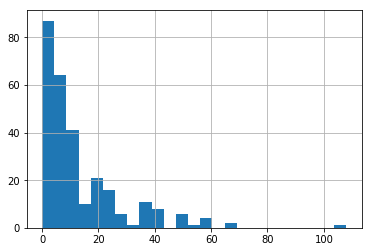

In [433]:
profile[(profile["discount_total_offers_count"] != 0) & (profile["bogo_total_offers_count"] != 0) & (profile["bogo_positive_response_aware"] == 0)]["bogo_avg_receive_to_view_time"].hist(bins=25)

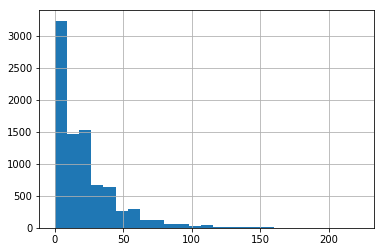

In [456]:
profile["discount_avg_receive_to_view_time"].hist(bins=25)

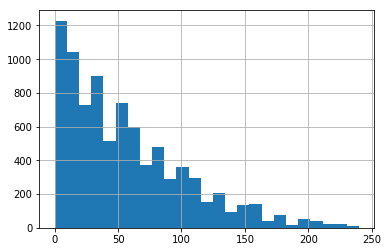

In [457]:
profile["discount_avg_view_to_complete_time"].hist(bins=25)

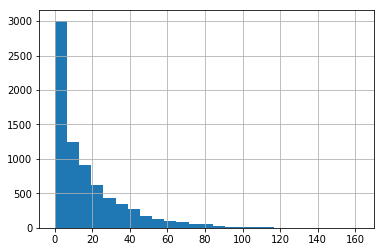

In [455]:
profile["bogo_avg_receive_to_view_time"].hist(bins=25)

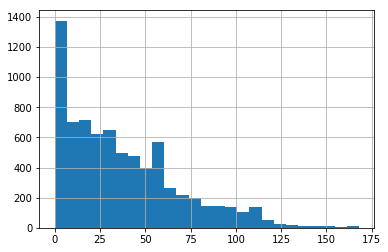

In [452]:
profile["bogo_avg_view_to_complete_time"].hist(bins=25)

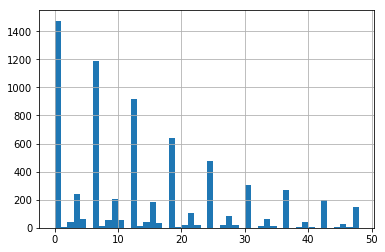

In [451]:
profile[(profile["bogo_avg_receive_to_view_time"] <= 48)]["bogo_avg_receive_to_view_time"].hist(bins=48)

In [450]:
profile[(profile["bogo_avg_receive_to_view_time"].notnull()) & (profile["bogo_avg_receive_to_view_time"] <= 24)]["bogo_avg_receive_to_view_time"].value_counts()

0.0     1475
6.0     1187
12.0     920
18.0     640
24.0     473
3.0      238
9.0      207
15.0     181
21.0     108
4.0       57
8.0       54
10.0      50
14.0      39
2.0       39
16.0      28
20.0      19
22.0      19
13.5      10
7.5        9
10.5       7
16.5       6
4.5        5
22.5       4
1.5        3
19.5       2
19.2       2
3.6        1
7.2        1
2.4        1
14.4       1
Name: bogo_avg_receive_to_view_time, dtype: int64

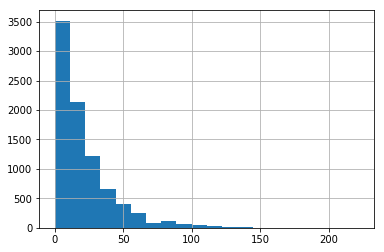

In [31]:
profile["discount_avg_receive_to_view_time"].hist(bins=20);

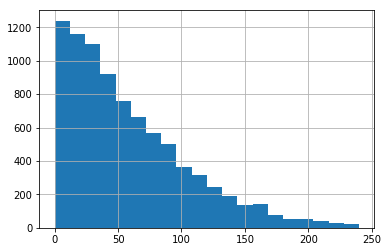

In [32]:
profile["discount_avg_view_to_complete_time"].hist(bins=20);

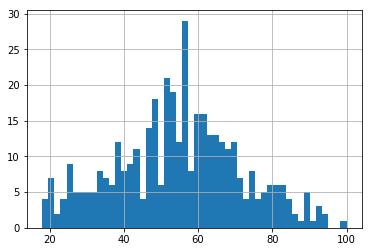

In [52]:
profile[(profile["discount_weak_positive_response"] == 1)]["age"].hist(bins=50);

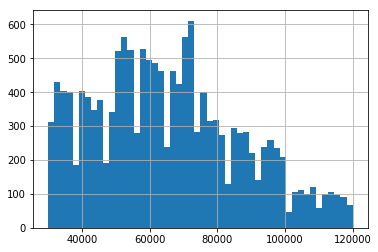

In [54]:
profile["income"].hist(bins=50);

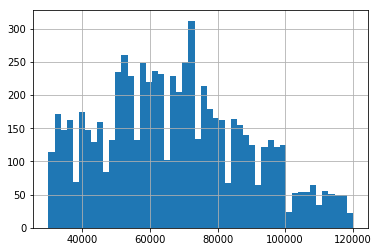

In [46]:
profile[(profile["discount_strong_positive_response"] == 1)]["income"].hist(bins=50);

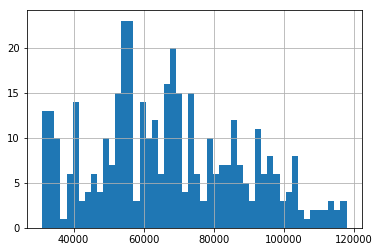

In [142]:
profile[(profile["discount_weak_positive_response"] == 1)]["income"].hist(bins=50);

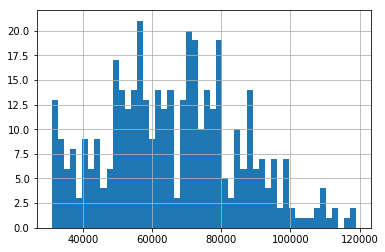

In [143]:
profile[(profile["discount_neutral_response"] == 1)]["income"].hist(bins=50);

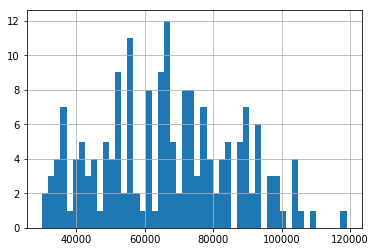

In [144]:
profile[(profile["discount_weak_negative_response"] == 1)]["income"].hist(bins=50);

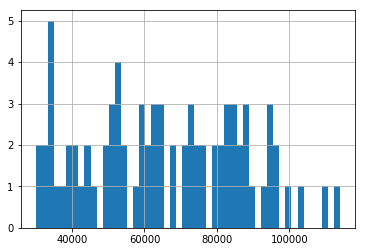

In [145]:
profile[(profile["discount_strong_negative_response"] == 1)]["income"].hist(bins=50);

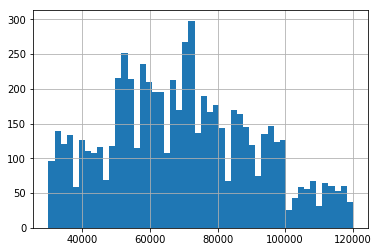

In [146]:
profile[(profile["bogo_strong_positive_response"] == 1)]["income"].hist(bins=50);

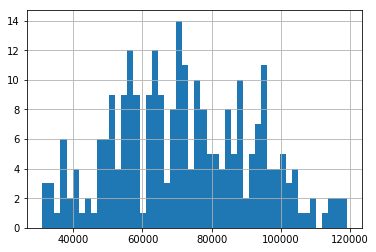

In [147]:
profile[(profile["bogo_weak_positive_response"] == 1)]["income"].hist(bins=50);

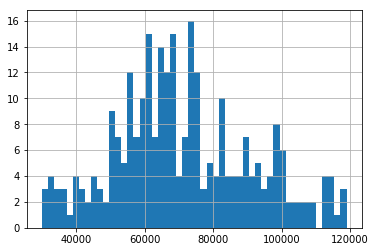

In [148]:
profile[(profile["bogo_neutral_response"] == 1)]["income"].hist(bins=50);

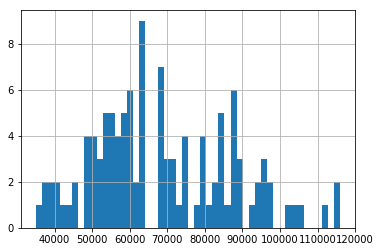

In [149]:
profile[(profile["bogo_weak_negative_response"] == 1)]["income"].hist(bins=50);

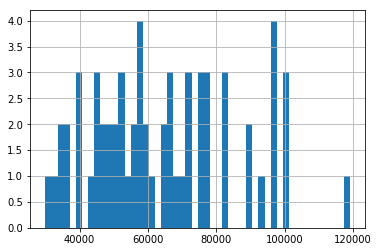

In [150]:
profile[(profile["bogo_strong_negative_response"] == 1)]["income"].hist(bins=50);

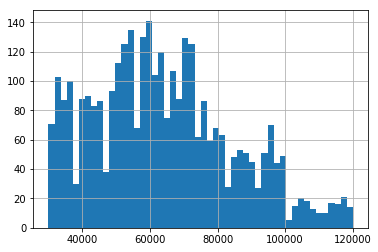

In [152]:
profile[(profile["informational_strong_positive_response"] == 1)]["income"].hist(bins=50);

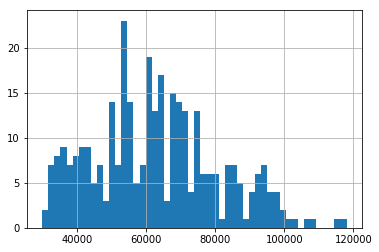

In [153]:
profile[(profile["informational_weak_positive_response"] == 1)]["income"].hist(bins=50);

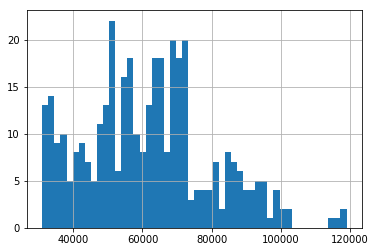

In [154]:
profile[(profile["informational_neutral_response"] == 1)]["income"].hist(bins=50);

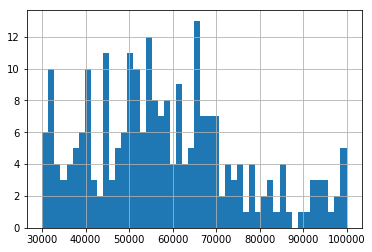

In [155]:
profile[(profile["informational_weak_negative_response"] == 1)]["income"].hist(bins=50);

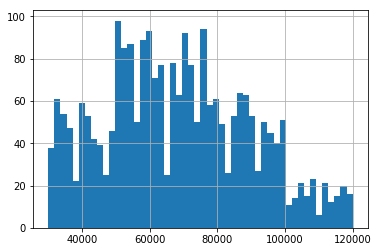

In [156]:
profile[(profile["informational_strong_negative_response"] == 1)]["income"].hist(bins=50);

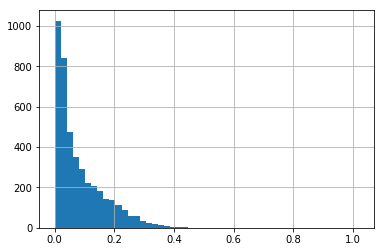

In [138]:
profile[(profile["income"] > 40000) & (profile["income"] < 60000)]["no_promotions_spending_per_hour"].hist(bins=50);

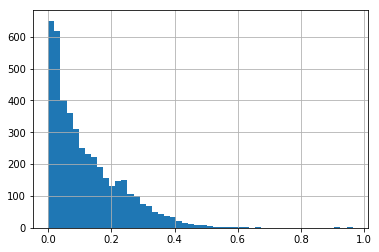

In [139]:
profile[(profile["income"] > 60000) & (profile["income"] < 80000)]["no_promotions_spending_per_hour"].hist(bins=50);

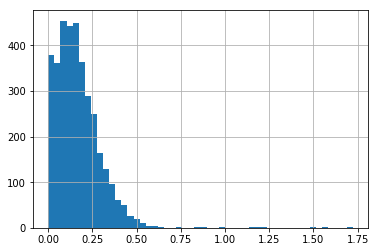

In [140]:
profile[(profile["income"] > 80000)]["no_promotions_spending_per_hour"].hist(bins=50);

In [60]:
profile[(profile["no_promotions_spending_per_hour"] > 0.7)]

,age,gender,id,income,tenure_length,joined_date,total_transaction_amount,total_reward_amount,discount_active_hours,bogo_active_hours,...,bogo_strong_positive_response,bogo_weak_positive_response,bogo_neutral_response,bogo_weak_negative_response,bogo_strong_negative_response,informational_strong_positive_response,informational_weak_positive_response,informational_neutral_response,informational_weak_negative_response,informational_strong_negative_response
739,50.0,M,7c8479d8241344f6a0c306621e191c75,51000.0,1763,2013-09-27,488.77,12.0,164,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
2681,58.0,F,6cf884a6c5ae4b2daccb6d3108028fef,110000.0,1085,2015-08-06,1165.26,13.0,0,14,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4044,63.0,F,72238c93bdfb4272a1f104a59ccc3a37,108000.0,241,2017-11-27,748.69,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
7785,60.0,M,ec8e29cea5e24a7d91896afb4c6c00c2,71000.0,202,2018-01-05,618.85,8.0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
8564,59.0,M,73adeca7df934d9a888ddfcdaad2dff0,71000.0,139,2018-03-09,693.80,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8697,71.0,F,9e523a3e05e14fd0bfec8ac108ce2cab,107000.0,50,2018-06-06,1035.01,2.0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
10138,66.0,M,ad1f0a409ae642bc9a43f31f56c130fc,80000.0,333,2017-08-27,1258.19,15.0,74,32,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
11305,64.0,F,7a153a17d9754d3686c37684146fb681,106000.0,33,2018-06-23,902.94,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0
12115,75.0,F,6d86fa31d7bb49a1be3197271181d5cf,98000.0,322,2017-09-07,703.89,10.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13634,37.0,M,c2390da2832148358ec29931c0487885,87000.0,271,2017-10-28,932.22,5.0,116,0,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0


In [64]:
profile[(profile["income"] > 80000)].iloc[0:20, 40:60]

,discount_to_no_promotions_spending_per_hour_ratio,bogo_to_no_promotions_spending_per_hour_ratio,informational_to_no_promotions_spending_per_hour_ratio,discount_strong_positive_response,discount_weak_positive_response,discount_neutral_response,discount_weak_negative_response,discount_strong_negative_response,bogo_strong_positive_response,bogo_weak_positive_response,bogo_neutral_response,bogo_weak_negative_response,bogo_strong_negative_response,informational_strong_positive_response,informational_weak_positive_response,informational_neutral_response,informational_weak_negative_response,informational_strong_negative_response
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.213729,12.855168,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
21,23.013991,88.466039,4.498654,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25,17186.363636,178000.000000,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
30,3.012170,1.207477,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
33,NaN,2.660953,0.000000,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
43,3.038681,NaN,NaN,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,7.386416,2.794545,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
58,1.447940,2.194066,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
65,1.132300,1.412418,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
